***Parameter Definitions***

In [1]:
nx, ny, nz              = 32, 32, 8                    # Spatial Dimension
m                       = 4                            # Number of Patterns
dd_factor               = 2                            # Detector Downsampling Factor

Load object

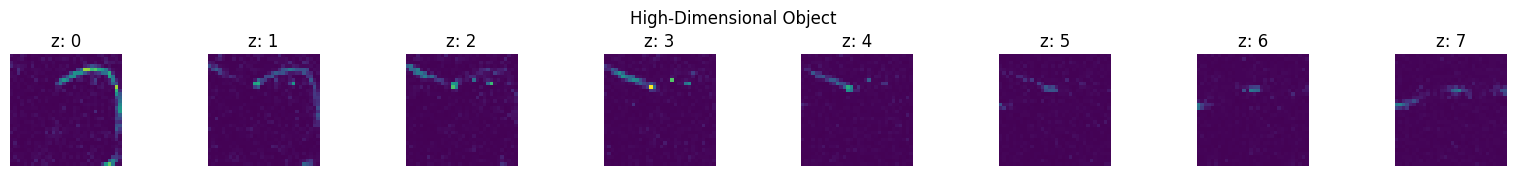

In [2]:
from libs.forward_lib.read_data import ReadData

RD = ReadData(nx, ny, nz, up_factor=0.25)
RD.load_object("blood_cell")
RD.visualize_data(is_orginal=True, n_planes=8)

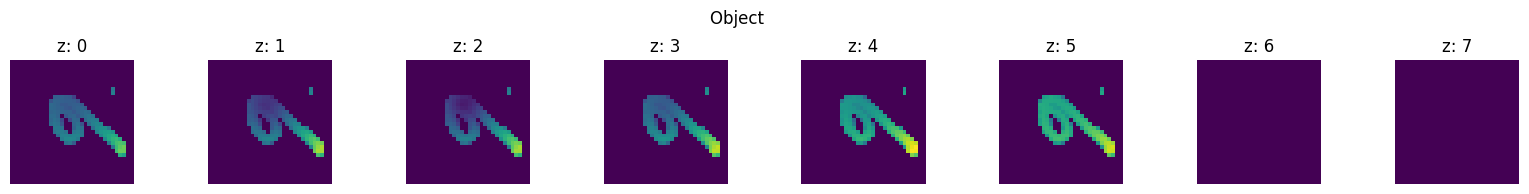

In [3]:
from libs.forward_lib.simulate_data import MnistSimulator

MS = MnistSimulator(nx, ny, nz, up_factor=(6/28,1,1))
MS.update_data()
MS.visualize_object(vis_planes=True)

Linearized Model

Linearized Model Specifications
----------------------------------------------
NA 				: 0.8
Space Dimension 		: 32.000um × 32.000um × 8.000um
Voxel Size 			: 1.0um × 1.0um × 1.0um
Original Shape 			: 32 × 32 × 8
D2NN Patterns 			: 4
# of Plane			: 1
Detector Pool size 		: 2×2
Computational Device 		: cpu




Pattern: 4/4	 Nz: 100%|██████████| 8/8 [00:01<00:00,  6.72it/s]


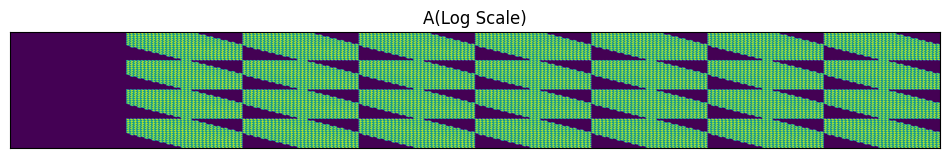

In [4]:
from libs.forward_lib.linearized_process_D2NN import LinearizedModel

LM = LinearizedModel(nx, ny, nz, m, dd_factor, n_planes=1)
LM.init_models()
print(LM)

LM.find_transformation()
LM.visualize_A()

FM = LM.A.cpu().numpy()

In [5]:
import numpy as np

X = RD.X.cpu().numpy().reshape(nx*ny*nz, 1)
y_clean = FM@X

def add_gaussian_noise(signal, snr_dB):
    signal_power = np.mean(signal**2)
    snr = 10**(snr_dB/10.0)
    noise_power = signal_power/snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

desired_snr_dB = 20.0
y_noisy = add_gaussian_noise(y_clean, desired_snr_dB).reshape(m*(nx//dd_factor)*(ny//dd_factor), 1)

Run twist


Initial objective = 2215.760703202929, nonzeros = 0
Incrementing S = 2
Incrementing S = 4
Incrementing S = 8
Incrementing S = 16
Incrementing S = 32
Incrementing S = 64
Incrementing S = 128
Incrementing S = 256
Incrementing S = 512
Incrementing S = 1024
Iteration = 2, objective = 336.0038041349589, nz = 8192, criterion = 84.83573593261862
Iteration = 3, objective = 139.68762000539843, nz = 8192, criterion = 58.42677425482609
Iteration = 4, objective = 89.38609481884814, nz = 8192, criterion = 36.010009465839794
Iteration = 5, objective = 83.34368004261297, nz = 8192, criterion = 6.759904645662007
Iteration = 6, objective = 51.73472396546384, nz = 8192, criterion = 37.926038376260465
Iteration = 7, objective = 48.43810309684925, nz = 8192, criterion = 6.3721628645690584
Iteration = 8, objective = 30.747677023073916, nz = 8192, criterion = 36.52171522572699
Iteration = 9, objective = 28.714294362207255, nz = 8192, criterion = 6.613126121172515
Iteration = 10, objective = 28.564066806686

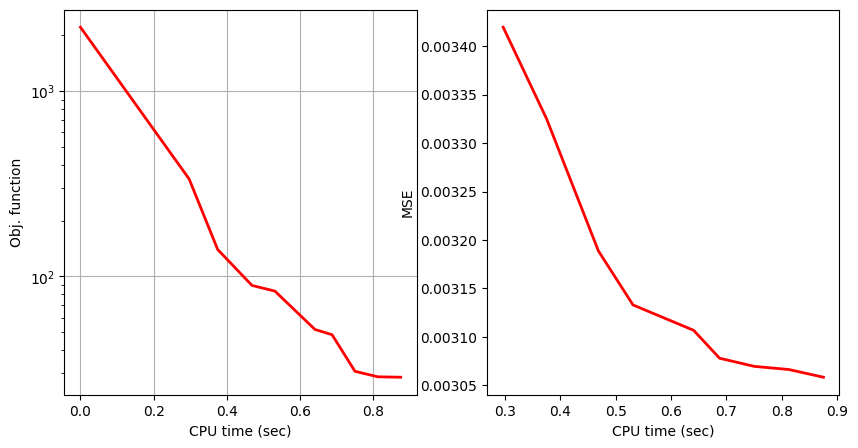

TwIST CPU time: 0.875
MSE Loss: 3.0582e-03


f:\miniconda3\envs\FYP\lib\site-packages\skimage\metrics\simple_metrics.py:163: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


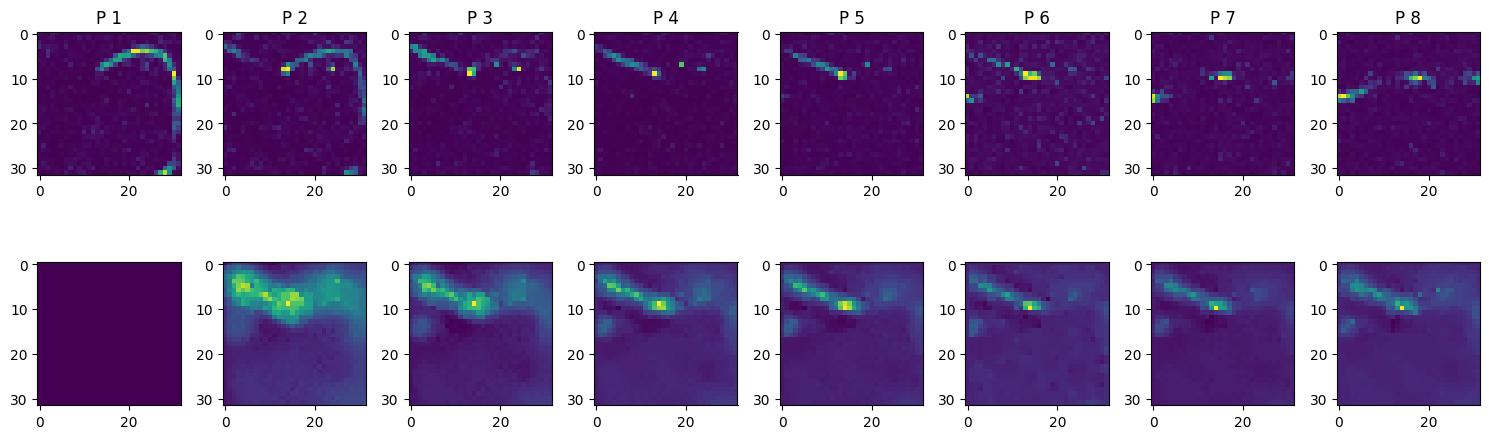

plane 1 | SSIM = 0.0000 | PSNR = -inf dB
plane 2 | SSIM = 0.0974 | PSNR = 6.0311 dB
plane 3 | SSIM = 0.2165 | PSNR = 8.8077 dB
plane 4 | SSIM = 0.3094 | PSNR = 11.9495 dB
plane 5 | SSIM = 0.3289 | PSNR = 13.6362 dB
plane 6 | SSIM = 0.6022 | PSNR = 25.1074 dB
plane 7 | SSIM = 0.4172 | PSNR = 17.9719 dB
plane 8 | SSIM = 0.4166 | PSNR = 17.9364 dB


In [6]:
import libs.reconstruction_lib.TWIST as TWIST
import libs.reconstruction_lib.twist_utils as utils

y = y_noisy

tau = 1/10 # Regularization parameter
Psi = 'TV' # denoising function ('TV', 'SOFT', 'SOFT_DWT')
Phi = 'TV' # regularization function ('TV', 'L1', 'L1_DWT')
lam1 = 1e-4 # twist parameter
stop_criterion = 1 # 0:non-zero components, 1:change in obj func, 2:estimate, 3:value of obj func 
tolA = 1e-2 # Stopping threshold
init = 0 # 0:zero, 1:random, 2:Aty, 3:init_x given by user
init_x = None # initial estimate

x_twist, dummy, obj_twist, times_twist, dummy, mse_twist, dummy = TWIST.TwIST(y, FM, tau, nx, ny, nz,
                                                                                Psi=Psi, Phi=Phi,
                                                                                lam1=1e-4, alpha=0, beta=0,
                                                                                stop_criterion=stop_criterion, tolA=tolA,
                                                                                init=init, init_x=init_x,
                                                                                enforceMonotone=1,
                                                                                true_x=X, compute_mse=1,
                                                                                verbose=1)

utils.plot_obj_mse(obj_twist, times_twist, mse_twist, figsize=(10,5))

ssim_values, psnr_values = utils.comparison2(X, x_twist, nx, ny, nz, figsize=(15, 5), planes_to_plot=range(nz))